In [210]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap, BoundaryNorm
import distinctipy

from paolucci_functions import *

# Create dataframe

In [238]:
import os
import pandas as pd
import re
import numpy as np

def find_last_energy_value(filename):
    pattern = r"SCF Done:  E\(UPBE-PBE\) =  (-?\d+\.\d+)     A\.U\. after    \d+ cycles"
    last_energy = None
    
    with open(filename, 'r') as file:
        for line in file:
            match = re.search(pattern, line)
            if match:
                last_energy = float(match.group(1))
    
    return last_energy

def parse_frequencies(file_path):
    pattern = r'Frequencies\s+--\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)'  # regex to find desired lines
    frequencies = []

    with open(file_path, 'r') as file:
        for line in file:
            match = re.search(pattern, line)
            if match:
                freq_values = match.groups()
                frequencies.extend(freq_values)
    
    # Convert strings to floats and cutoff frequencies below 100 cm^-1
    no_low_freq = [float(x) for x in frequencies if float(x) >= 100]
    
    return no_low_freq

def calculate_zpe(frequencies):
    h = 6.62607015e-34  # Planck's constant in J*s
    cm_to_hz = 2.99793e10  # convert cm^-1 to Hz
    Na = 6.022e23  # Avogadro's number 
    
    frequencies_array = np.array(frequencies, dtype=float)
    zpe = 0.5 * (h/1000) * np.sum(frequencies_array) * cm_to_hz * Na  # zero point energy in units of kJ/mol
    
    return zpe

def parse_ligand_file(file_name, file_dir):
    # Remove the file extension
    base_name = os.path.splitext(file_name)[0]
    
    # Initialize ligand counts
    n_nh3 = 0
    n_h2o = 0
    n_c2h4 = 0
    
    # Define regular expressions for ligands
    nh3_pattern = re.compile(r'(\d+)_nh3')
    h2o_pattern = re.compile(r'(\d+)_h2o')
    c2h4_pattern = re.compile(r'(\d+)_c2h4')
    
    # Find all matches
    nh3_match = nh3_pattern.search(base_name)
    h2o_match = h2o_pattern.search(base_name)
    c2h4_match = c2h4_pattern.search(base_name)
    
    if nh3_match:
        n_nh3 = int(nh3_match.group(1))
    if h2o_match:
        n_h2o = int(h2o_match.group(1))
    if c2h4_match:
        n_c2h4 = int(c2h4_match.group(1))
    
    # The remaining part after the ligand patterns is the description
    description_parts = nh3_pattern.sub('', base_name)
    description_parts = h2o_pattern.sub('', description_parts)
    description_parts = c2h4_pattern.sub('', description_parts)
    description = description_parts.strip('_')
    
    # Read the log file to find the total energy and frequencies
    total_energy = find_last_energy_value(os.path.join(file_dir, file_name))
    frequencies = parse_frequencies(os.path.join(file_dir, file_name))
    zpe = calculate_zpe(frequencies)
    
    return n_nh3, n_h2o, n_c2h4, description, total_energy, zpe, os.path.join(file_dir, file_name)

def extract_data_from_directory(base_dir):
    data = []
    
    for metal_dir in os.listdir(base_dir):
        if os.path.isdir(os.path.join(base_dir, metal_dir)):
            # Extract metal and charge information
            metal = ''.join([i for i in metal_dir if not i.isdigit()])
            charge = ''.join([i for i in metal_dir if i.isdigit()])
            
            for geometry_dir in os.listdir(os.path.join(base_dir, metal_dir)):
                if os.path.isdir(os.path.join(base_dir, metal_dir, geometry_dir)):
                    geometry = geometry_dir.replace('_', ' ').capitalize()
                    
                    for ligand_file in os.listdir(os.path.join(base_dir, metal_dir, geometry_dir)):
                        if ligand_file.endswith('.log'):  # replace with your file extension
                            n_nh3, n_h2o, n_c2h4, description, total_energy, zpe, file_path = parse_ligand_file(ligand_file, os.path.join(base_dir, metal_dir, geometry_dir))
                            
                            data.append({
                                'Metal': metal.capitalize(),
                                'Charge': charge,
                                'Geometry': geometry,
                                'NH3': n_nh3,
                                'H2O': n_h2o,
                                'C2H4': n_c2h4,
                                'Description': description,
                                'Total Energy (Hartree)': total_energy,
                                'ZPE (kJ/mol)': zpe,
                                'File Path': file_path
                            })
    
    return pd.DataFrame(data)

# Set the base directory path
base_directory = '/Users/mohan/Desktop/Research/paolucci/data/freq'

# Extract the data into a dataframe
df = extract_data_from_directory(base_directory)

# Display the dataframe
df


,Metal,Charge,Geometry,NH3,H2O,C2H4,Description,Total Energy (Hartree),ZPE (kJ/mol),File Path
0,Cu,2,Square planar,1,3,0,,-1925.257977,293.629551,/Users/mohan/Desktop/Research/paolucci/data/fr...
1,Cu,2,Square planar,0,4,0,,-1945.082482,258.343882,/Users/mohan/Desktop/Research/paolucci/data/fr...
2,Cu,2,Square planar,2,2,0,90apart,-1905.432240,327.923744,/Users/mohan/Desktop/Research/paolucci/data/fr...
3,Cu,2,Square planar,2,2,0,180apart,-1905.430468,327.990354,/Users/mohan/Desktop/Research/paolucci/data/fr...
4,Cu,2,Square planar,4,0,0,,-1865.770866,401.772002,/Users/mohan/Desktop/Research/paolucci/data/fr...
...,...,...,...,...,...,...,...,...,...,...
63,Co,2,Tetrahedral,0,0,4,,-1695.873238,552.205013,/Users/mohan/Desktop/Research/paolucci/data/fr...
64,Co,2,Tetrahedral,0,4,0,,-1687.370629,261.037222,/Users/mohan/Desktop/Research/paolucci/data/fr...
65,Co,2,Tetrahedral,0,0,3,1n2,-1617.357580,409.382533,/Users/mohan/Desktop/Research/paolucci/data/fr...
66,Co,2,Tetrahedral,4,0,0,,-1608.059847,408.647863,/Users/mohan/Desktop/Research/paolucci/data/fr...


# Interpolate NIST-Janaf

In [258]:
import requests
from bs4 import BeautifulSoup

kb = 1.381e-23

h_p = 6.626e-34

Na = 6.022e23

R = 8.314

nh3_url = "https://janaf.nist.gov/tables/H-083.html"

h2o_url = "https://janaf.nist.gov/tables/H-064.html"

c2h4_url = "https://janaf.nist.gov/tables/C-128.html"

nh3_results = nist_collector(nh3_url)

h2o_results = nist_collector(h2o_url)

c2h4_results = nist_collector(c2h4_url)

zero_k_nh3_entropy = nh3_results[0][1]
zero_k_nh3_enthalpy = nh3_results[0][2]

zero_k_h2o_entropy = h2o_results[0][1]
zero_k_h2o_enthalpy = h2o_results[0][2]

zero_k_c2h4_entropy = c2h4_results[0][1]
zero_k_c2h4_enthalpy = c2h4_results[0][2]

In [274]:
import matplotlib.pyplot as plt

temp_step = 0.05

interp_temp = np.arange(250, 500 + temp_step, temp_step)

# interpolate entropy and enthalpy over specified temp-range 

entropy_nh3 = cubicspline_interp(nh3_results[1:-1, 0], nh3_results[1:-1, 1], interp_temp) # [1:-1, 0] Ignore first and last element of first column (0, 298.15 K)

enthalpy_nh3 = cubicspline_interp(nh3_results[1:-1, 0], nh3_results[1:-1, 2], interp_temp)

entropy_h2o = cubicspline_interp(h2o_results[1:-1, 0], h2o_results[1:-1, 1], interp_temp) # [1:-1, 0] Ignore first and last element of first column (0, 298.15 K)

enthalpy_h2o = cubicspline_interp(h2o_results[1:-1, 0], h2o_results[1:-1, 2], interp_temp)

entropy_c2h4 = cubicspline_interp(c2h4_results[1:-1, 0], c2h4_results[1:-1, 1], interp_temp) # [1:-1, 0] Ignore first and last element of first column (0, 298.15 K)

enthalpy_c2h4 = cubicspline_interp(c2h4_results[1:-1, 0], c2h4_results[1:-1, 2], interp_temp)

# Calculate $\Delta E , \Delta S$

The general equation is:

$$ M(NH_3)_4 + y H_2 O \to y NH_3 + M(NH_3)_{4 - y}(H_2 O)_y$$

$$\Delta E = E_{M(NH_3)_{4 - y}(H_2 O)_y} + E_{y NH_3} - E_{M(NH_3)_4} - E_{y H_2 O} $$

In [275]:
def filter_dataframe(data: pd.DataFrame, metal:str, charge: int, geom: str) -> pd.DataFrame:
    """
    Returns dataframe with grouping specified by arguments
    """
    if geom:
        return data[(data['Metal'] == metal) & (data['Charge'] == str(charge)) & (data['Geometry'] == geom)]
    else:
        return data[(data['Metal'] == metal) & (data['Charge'] == str(charge))]
    
# new = filter_dataframe(data = df, metal = 'Cu', charge = 2, geom = 'Square planar')

new = filter_dataframe(data = df, metal = 'Pd', charge = 2, geom ="Square planar") # CHANGE GEOMETRY HERE

new.insert(10, "Entropy (kJ/mol*K)", None) # insert new, empty column at the end of the dataframe

new

,Metal,Charge,Geometry,NH3,H2O,C2H4,Description,Total Energy (Hartree),ZPE (kJ/mol),File Path,Entropy (kJ/mol*K)
23,Pd,2,Square planar,0,0,4,,-441.309638,555.996631,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
24,Pd,2,Square planar,2,0,1,n180,-318.693274,324.382673,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
25,Pd,2,Square planar,1,0,2,n90,-340.797516,376.668381,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
26,Pd,2,Square planar,1,0,2,n180,-340.792663,373.478670,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
27,Pd,2,Square planar,0,3,1,,-434.876410,335.413556,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
28,Pd,2,Square planar,1,1,2,c2h4180apart,-417.203728,443.621472,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
29,Pd,2,Square planar,1,3,0,,-412.907647,299.564815,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
30,Pd,2,Square planar,1,0,3,,-419.346217,518.260738,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
31,Pd,2,Square planar,0,4,0,,-432.719179,264.934707,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
32,Pd,2,Square planar,0,1,2,n90,-360.618231,340.798166,/Users/mohan/Desktop/Research/paolucci/data/fr...,None


In [291]:
init_nh3 = 0 # CHANGE INIT NUM NH3 HERE
final_nh3 = 1 # CHANGE FINAL NUM NH3 HERE

rxn_df = new[new['NH3'].isin([init_nh3, final_nh3])]

rxn_df

,Metal,Charge,Geometry,NH3,H2O,C2H4,Description,Total Energy (Hartree),ZPE (kJ/mol),File Path,Entropy (kJ/mol*K)
23,Pd,2,Square planar,0,0,4,,-441.309638,555.996631,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
25,Pd,2,Square planar,1,0,2,n90,-340.797516,376.668381,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
26,Pd,2,Square planar,1,0,2,n180,-340.792663,373.478670,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
27,Pd,2,Square planar,0,3,1,,-434.876410,335.413556,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
28,Pd,2,Square planar,1,1,2,c2h4180apart,-417.203728,443.621472,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
29,Pd,2,Square planar,1,3,0,,-412.907647,299.564815,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
30,Pd,2,Square planar,1,0,3,,-419.346217,518.260738,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
31,Pd,2,Square planar,0,4,0,,-432.719179,264.934707,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
32,Pd,2,Square planar,0,1,2,n90,-360.618231,340.798166,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
33,Pd,2,Square planar,0,0,3,n180,-362.707647,406.996734,/Users/mohan/Desktop/Research/paolucci/data/fr...,None


In [292]:
def reference_energy(reduced_data: pd.DataFrame, start_nh3:int) -> np.float64:
    """
    Returns lowest energy associated with complete saturation of ammonia (lowest if comparing b/t geometries)
    """
    intermediate = reduced_data[(reduced_data['NH3'] == start_nh3)]
    return intermediate['Total Energy (Hartree)'].values

def reference_entropy(reduced_data: pd.DataFrame, start_nh3:int) -> np.float64:
    """
    Returns energy associated with complete saturation of ammonia
    """
    intermediate = reduced_data[(reduced_data['NH3'] == start_nh3)]
    return intermediate["Entropy (kJ/mol*K)"].values

def reference_energy_entropy(reduced_data: pd.DataFrame, start_nh3:int) -> np.float64:
    """
    Returns lowest energy associated with complete saturation of ammonia and the entropy of that species
    """
    intermediate = reduced_data[(reduced_data['NH3'] == start_nh3)]
    min_index = intermediate['Total Energy (Hartree)'].idxmin() # lowest energy of full saturation with NH3 if mult. geometries
    return intermediate.loc[min_index, 'Total Energy (Hartree)'], intermediate.loc[min_index, 'Entropy (kJ/mol*K)']

e_nh3 = -56.4923518650 # hartree
e_h2o = -76.3434909651 # hartree
e_c2h4 = -78.4923922995 # hartree

har_to_kjmol = 2625.5

In [293]:
for row in rxn_df.itertuples(index=True):
    
    s_trans, s_vib, s_rot = calc_entropy(infile = row[10], temperature = interp_temp)
    
    total_entropy = (s_trans + s_vib + s_rot)

    rxn_df.at[row[0], 'Entropy (kJ/mol*K)']  = total_entropy/1000 # total_entropy is in J/mol*K so divide to get kJ

rxn_df

,Metal,Charge,Geometry,NH3,H2O,C2H4,Description,Total Energy (Hartree),ZPE (kJ/mol),File Path,Entropy (kJ/mol*K)
23,Pd,2,Square planar,0,0,4,,-441.309638,555.996631,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.42097665224601477, 0.42101410572052556, 0.4..."
25,Pd,2,Square planar,1,0,2,n90,-340.797516,376.668381,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.3341725383207743, 0.3341942876157616, 0.334..."
26,Pd,2,Square planar,1,0,2,n180,-340.792663,373.478670,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.34567905855293, 0.3457015971504484, 0.34572..."
27,Pd,2,Square planar,0,3,1,,-434.876410,335.413556,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.36831309611363605, 0.3683413505695188, 0.36..."
28,Pd,2,Square planar,1,1,2,c2h4180apart,-417.203728,443.621472,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.39155342703865303, 0.3915844515142171, 0.39..."
29,Pd,2,Square planar,1,3,0,,-412.907647,299.564815,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.3552611886877602, 0.35528676692720546, 0.35..."
30,Pd,2,Square planar,1,0,3,,-419.346217,518.260738,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.3991422437068075, 0.3991753759168507, 0.399..."
31,Pd,2,Square planar,0,4,0,,-432.719179,264.934707,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.3603013798808495, 0.36032821150381317, 0.36..."
32,Pd,2,Square planar,0,1,2,n90,-360.618231,340.798166,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.3587549014528096, 0.35878036930848795, 0.35..."
33,Pd,2,Square planar,0,0,3,n180,-362.707647,406.996734,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.34574881358037124, 0.3457716106679087, 0.34..."


In [294]:
intermediate = rxn_df[(rxn_df['NH3'] == init_nh3)]

min_index = intermediate['Total Energy (Hartree)'].idxmin() # lowest energy of full saturation with NH3 if mult. geometries

init_cond = intermediate.loc[min_index]

rxn_df.reset_index(drop=True, inplace=True) # reset indices for plotting more easily later

my_colors = distinctipy.get_colors(rxn_df.shape[0], pastel_factor=1.0)

my_colormap = ListedColormap(my_colors)

rxn_df

,Metal,Charge,Geometry,NH3,H2O,C2H4,Description,Total Energy (Hartree),ZPE (kJ/mol),File Path,Entropy (kJ/mol*K)
0,Pd,2,Square planar,0,0,4,,-441.309638,555.996631,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.42097665224601477, 0.42101410572052556, 0.4..."
1,Pd,2,Square planar,1,0,2,n90,-340.797516,376.668381,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.3341725383207743, 0.3341942876157616, 0.334..."
2,Pd,2,Square planar,1,0,2,n180,-340.792663,373.478670,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.34567905855293, 0.3457015971504484, 0.34572..."
3,Pd,2,Square planar,0,3,1,,-434.876410,335.413556,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.36831309611363605, 0.3683413505695188, 0.36..."
4,Pd,2,Square planar,1,1,2,c2h4180apart,-417.203728,443.621472,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.39155342703865303, 0.3915844515142171, 0.39..."
5,Pd,2,Square planar,1,3,0,,-412.907647,299.564815,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.3552611886877602, 0.35528676692720546, 0.35..."
6,Pd,2,Square planar,1,0,3,,-419.346217,518.260738,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.3991422437068075, 0.3991753759168507, 0.399..."
7,Pd,2,Square planar,0,4,0,,-432.719179,264.934707,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.3603013798808495, 0.36032821150381317, 0.36..."
8,Pd,2,Square planar,0,1,2,n90,-360.618231,340.798166,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.3587549014528096, 0.35878036930848795, 0.35..."
9,Pd,2,Square planar,0,0,3,n180,-362.707647,406.996734,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.34574881358037124, 0.3457716106679087, 0.34..."


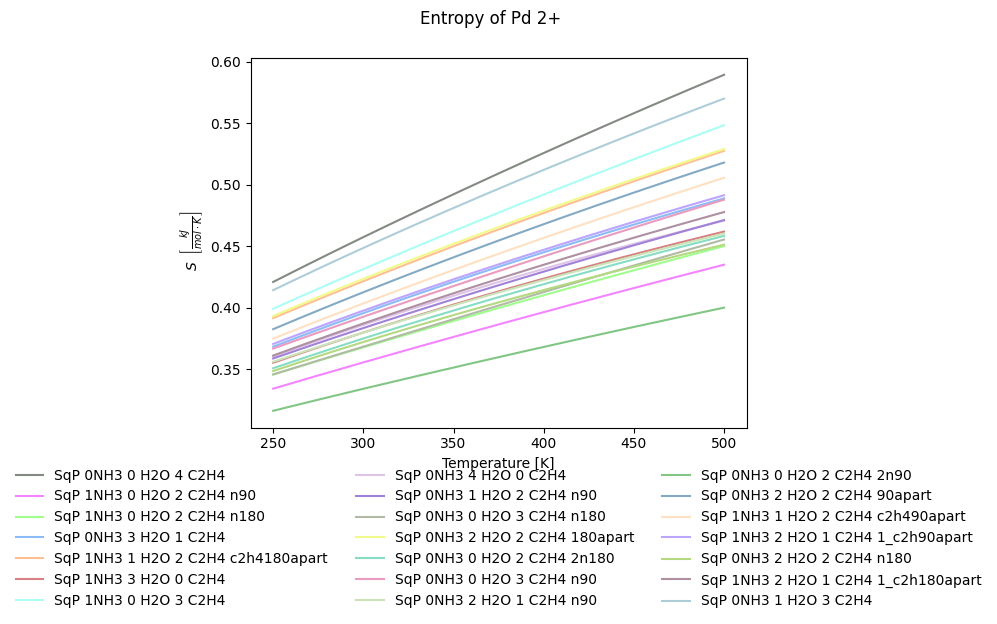

In [295]:
fig, ax = plt.subplots()

for row in rxn_df.itertuples(index=True):
    # ax.plot(interp_temp, row[-1], label = str(row[4])+"NH3 "+str(row[5])+" H2O "+ str(row[7]), color = colors[row[0]])
    linestyle = '--' if row[3] == 'Tetrahedral' else '-'
    Geom = 'Tet' if row[3] == 'Tetrahedral' else 'SqP'
    ax.plot(interp_temp, row[-1], label = Geom+" "+str(row[4])+"NH3 "+str(row[5])+" H2O "+str(row[6])+" C2H4 "+ str(row[7]), linestyle = linestyle, color = my_colors[row[0]])

ax.set_xlabel("Temperature [K]")
ax.set_ylabel(r" $ S  \; \; \left[ \frac{kJ}{mol \cdot K} \right] $")
plt.legend(ncol=3, bbox_to_anchor=(0.5, -0.3), loc='center', frameon = False)
# plt.suptitle(f"Free Energy of {self.data['Metal'][0]} {self.data['Charge'][0]}")
plt.suptitle(f"Entropy of {new['Metal'].values[0]} {new['Charge'].values[0]}+")

# plt.savefig("/Users/mohan/Desktop/s.png", dpi = 400, bbox_inches='tight')

plt.show();

$$ Pd_{(H_2 O)_4} + ? = Pd_{(H_2 O)_3 (NH_3)} + ?$$

If we do products - reactants, we see the reactant side loses 1 $H_2 O$ and the reactant side gains 1 $NH_3$



Products - Reactants

In [296]:
# for row in rxn_df.itertuples(index=True):
#     # row[4] = # NH3, row[5] = # H2O, row[6] = # C2H4, row[8] = Total Energy, row[11] = Entropy
#     print(row[11])

for i in range(rxn_df.shape[0]):
    delta_e = (rxn_df.loc[i, 'Total Energy (Hartree)'] - ((rxn_df.loc[i, 'H2O'] - init_cond['H2O']) * e_h2o) - ((rxn_df.loc[i, 'C2H4'] - init_cond['C2H4']) * e_c2h4)
                - ((rxn_df.loc[i, 'NH3'] - init_cond['NH3']) * e_nh3) - init_cond['Total Energy (Hartree)']) * har_to_kjmol
    # print(f"H2O: {(rxn_df.loc[i, 'H2O'] - init_cond['H2O'])}")
    rxn_df.loc[i, 'Delta E (kJ/mol)'] = delta_e


delta_s = (rxn_df['Entropy (kJ/mol*K)'].apply(lambda x: x - init_cond['Entropy (kJ/mol*K)'])) 

rxn_df.loc[rxn_df.index, 'Delta S (kJ/mol*K)'] = delta_s # append results back to corresponding row

rxn_df

/var/folders/2h/yqm73phx7ljgrfkrgb88dx000000gn/T/ipykernel_24363/366820880.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rxn_df.loc[i, 'Delta E (kJ/mol)'] = delta_e
/var/folders/2h/yqm73phx7ljgrfkrgb88dx000000gn/T/ipykernel_24363/366820880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rxn_df.loc[rxn_df.index, 'Delta S (kJ/mol*K)'] = delta_s # append results back to corresponding row


,Metal,Charge,Geometry,NH3,H2O,C2H4,Description,Total Energy (Hartree),ZPE (kJ/mol),File Path,Entropy (kJ/mol*K),Delta E (kJ/mol),Delta S (kJ/mol*K)
0,Pd,2,Square planar,0,0,4,,-441.309638,555.996631,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.42097665224601477, 0.42101410572052556, 0.4...",0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Pd,2,Square planar,1,0,2,n90,-340.797516,376.668381,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.3341725383207743, 0.3341942876157616, 0.334...",51.693559,"[-0.08680411392524046, -0.08681981810476397, -..."
2,Pd,2,Square planar,1,0,2,n180,-340.792663,373.478670,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.34567905855293, 0.3457015971504484, 0.34572...",64.436959,"[-0.07529759369308475, -0.07531250857007715, -..."
3,Pd,2,Square planar,0,3,1,,-434.876410,335.413556,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.36831309611363605, 0.3683413505695188, 0.36...",-35.380635,"[-0.05266355613237872, -0.05267275515100678, -..."
4,Pd,2,Square planar,1,1,2,c2h4180apart,-417.203728,443.621472,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.39155342703865303, 0.3915844515142171, 0.39...",-112.978554,"[-0.029423225207361736, -0.029429654206308442,..."
5,Pd,2,Square planar,1,3,0,,-412.907647,299.564815,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.3552611886877602, 0.35528676692720546, 0.35...",-117.498394,"[-0.06571546355825458, -0.0657273387933201, -0..."
6,Pd,2,Square planar,1,0,3,,-419.346217,518.260738,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.3991422437068075, 0.3991753759168507, 0.399...",-96.143567,"[-0.021834408539207262, -0.02183872980367485, ..."
7,Pd,2,Square planar,0,4,0,,-432.719179,264.934707,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.3603013798808495, 0.36032821150381317, 0.36...",-13.511452,"[-0.06067527236516529, -0.06068589421671239, -..."
8,Pd,2,Square planar,0,1,2,n90,-360.618231,340.798166,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.3587549014528096, 0.35878036930848795, 0.35...",131.573790,"[-0.06222175079320519, -0.06223373641203761, -..."
9,Pd,2,Square planar,0,0,3,n180,-362.707647,406.996734,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.34574881358037124, 0.3457716106679087, 0.34...",287.751388,"[-0.07522783866564353, -0.07524249505261688, -..."


In [297]:
# rxn_df_new = rxn_df.drop(18)

# rxn_df_new.reset_index(drop=True, inplace=True) # reset indices for plotting more easily later

# rxn_df = rxn_df_new

# rxn_df

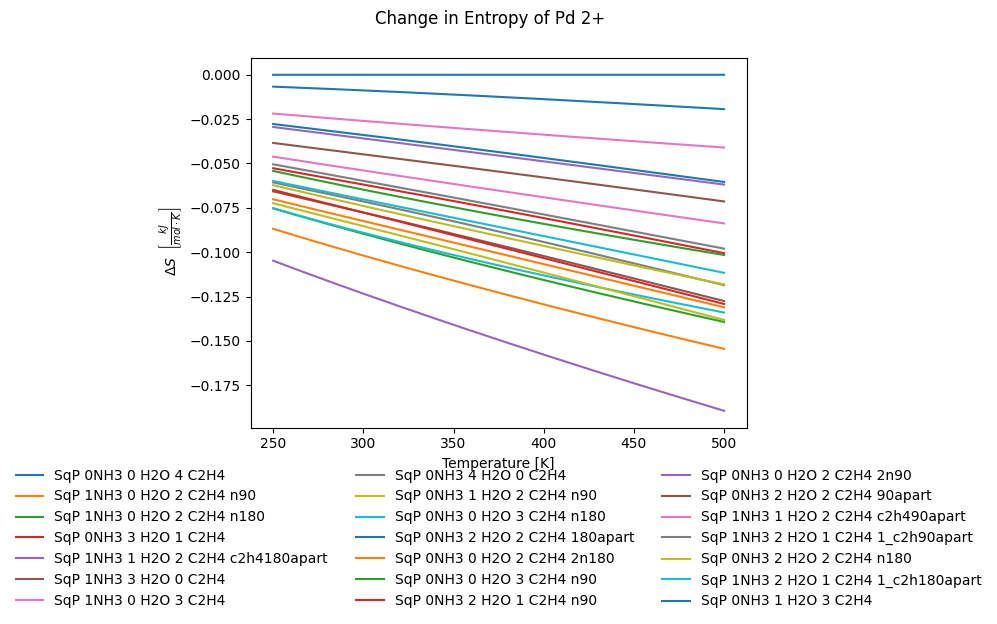

In [298]:
fig, ax = plt.subplots()

for row in rxn_df.itertuples(index=True):
    linestyle = '--' if row[3] == 'Tetrahedral' else '-'
    Geom = 'Tet' if row[3] == 'Tetrahedral' else 'SqP'
    # ax.plot(interp_temp, row[-1], label = str(row[4])+"NH3 "+str(row[5])+" H2O "+ str(row[7]), color = colors[row[0]])
    ax.plot(interp_temp, row[-1], label = Geom+" "+str(row[4])+"NH3 "+str(row[5])+" H2O "+str(row[6])+" C2H4 "+ str(row[7]), linestyle = linestyle)

ax.set_xlabel("Temperature [K]")
ax.set_ylabel(r" $ \Delta S  \; \; \left[ \frac{kJ}{mol \cdot K} \right] $")
plt.legend(ncol=3, bbox_to_anchor=(0.5, -0.3), loc='center', frameon = False)
plt.suptitle(f"Change in Entropy of {new['Metal'].values[0]} {new['Charge'].values[0]}+")

# plt.savefig("/Users/mohan/Desktop/delta_s.png", dpi = 400, bbox_inches='tight')

plt.show();

In [299]:
from matplotlib.colors import BoundaryNorm, ListedColormap
import matplotlib.colors as mcolors


class fourfold():
    def __init__(self, data, temperature:np.ndarray, p_nh3:np.ndarray, p_h2o:np.ndarray, p_c2h4:np.ndarray, in_cond:pd.DataFrame):
            self.data = data 
            self.temperature = temperature
            self.p_nh3 = p_nh3
            self.p_h2o = p_h2o
            self.p_c2h4 = p_c2h4
            self.nh3_i = in_cond['NH3']
            self.h2o_i = in_cond['H2O']
            self.c2h4_i = in_cond['C2H4']

    def no_mu(self):
        
        dE_TdS = []

        for delta in zip(self.data['Delta E (kJ/mol)'].values, self.data['Delta S (kJ/mol*K)'].values):
            # delta[0] = dE --> delta[1] = dS
            # dE - TdS
            dE_TdS.append(delta[0] - (self.temperature * delta[1]))
        
        return dE_TdS

    def plot_no_mu(self, outfile = None):

        dE_TdS = self.no_mu()

        colors = ['#51a885', 'r', '#ed8c37', '#f5a396', '#986b9b', '#267a9e']

        linestyles = ['-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--'] # dashed lines for one type of geom

        # Iterate over rows
        
        fig, ax = plt.subplots()

        for row in self.data.itertuples(index=True):
            linestyle = '--' if row[3] == 'Tetrahedral' else '-'
            Geom = 'Tet' if row[3] == 'Tetrahedral' else 'SqP'
            # ax.plot(self.temperature, dE_TdS[row[0]]) # , color = colors[row[0]]
            ax.plot(self.temperature, dE_TdS[row[0]], label = ' '+str(row[4])+"NH3 "+str(row[5])+" H2O "+ str(row[6])+" C2H4 "+str(row[7]), linestyle = linestyle) # , color = colors[row[0]]
            # print(row[4], "NH3", row[5], "H2O", row[7], 'dE =', row[-1])

        ax.set_xlabel("Temperature [K]")
        ax.set_ylabel(r" $\Delta E - T \Delta S  \; \; \left[ \frac{kJ}{mol} \right] $")
        plt.legend(ncol=3, bbox_to_anchor=(0.5, -0.3), loc='center', frameon = False)
        plt.suptitle(f"Free Energy of {self.data['Metal'][0]} {self.data['Charge'][0]}")
        
        if outfile:
            plt.savefig(outfile, dpi = 400, bbox_inches='tight')

        plt.show();


    def plot_no_mu_single(self, index, outfile = None):
        dE_TdS = self.no_mu()

        fig, ax = plt.subplots()

        interest = self.data.loc[index, :]
        
        ax.plot(self.temperature, dE_TdS[index], label = interest['Geometry']+' '+str(interest['NH3'])+r"N$H_3$ "+str(interest['H2O'])+r"H$_2$O "+str(interest['Description'])+r" $\Delta$ E = "+str(int(interest['Delta E (kJ/mol)'])))

        ax.set_xlabel("Temperature [K]")
        ax.set_ylabel(r" $\Delta E - T \Delta S  \; \; \left[ \frac{kJ}{mol} \right] $")
        plt.legend(ncol=3, bbox_to_anchor=(0.5, -0.2), loc='center', frameon = False)
        plt.suptitle(f"Free Energy of {self.data['Metal'][0]} {self.data['Charge'][0]}")
        
        if outfile:
            plt.savefig(outfile, dpi = 400, bbox_inches='tight')

        plt.show();
        
    def vary_temp(self):

        mu_nh3 = np.zeros_like(self.temperature, dtype = np.float32) # constant temp along row; constant pres. down column 
        mu_h2o = np.zeros_like(self.temperature, dtype = np.float32) # constant temp along row; constant pres. down column 
        mu_c2h4 = np.zeros_like(self.temperature, dtype = np.float32) # constant temp along row; constant pres. down column 

        for t, temp in enumerate(self.temperature):
            mu_nh3[t] = (enthalpy_nh3[t] - zero_k_nh3_enthalpy) - (temp * entropy_nh3[t]) + (0.008314 * temp * np.log(self.p_nh3))
            mu_h2o[t] = (enthalpy_h2o[t] - zero_k_h2o_enthalpy) - (temp * entropy_h2o[t]) + (0.008314 * temp * np.log(self.p_h2o))
            mu_c2h4[t] = (enthalpy_c2h4[t] - zero_k_c2h4_enthalpy) - (temp * entropy_c2h4[t]) + (0.008314 * temp * np.log(self.p_c2h4))

        dE_TdS_mu = []

        for delta in zip(self.data['Delta E (kJ/mol)'].values, self.data['Delta S (kJ/mol*K)'].values, self.data['H2O'], self.data['C2H4'], self.data['NH3']):
            # delta[0] = dE --> delta[1] = dS --> delta[2] = y from yH2O --> delta[3] = z from zC2H4 --> delta[4] = x NH3
            dE_TdS_mu.append(delta[0] - (self.temperature * delta[1]) - ((delta[2] - self.h2o_i) * mu_h2o) - ((delta[3] - self.c2h4_i) * mu_c2h4) + ((delta[4] - self.nh3_i) * mu_nh3)) 
        
        return dE_TdS_mu, mu_nh3, mu_h2o, mu_c2h4
    
    def plot_vary_temp(self, outfile = None):
            
        dE_TdS_mu, mu_nh3, mu_h2o, mu_c2h4 = self.vary_temp()
        colors = ['#51a885', 'r', '#ed8c37', '#f5a396', '#986b9b', '#267a9e']

        fig, ax = plt.subplots()

        for row in self.data.itertuples(index=True):
            linestyle = '--' if row[3] == 'Tetrahedral' else '-'
            ax.plot(self.temperature, dE_TdS_mu[row[0]], label = ' '+str(row[4])+"NH3 "+str(row[5])+" H2O "+ str(row[6])+" C2H4 "+str(row[7]), linestyle = linestyle) # , color = colors[row[0]]
            

        ax.set_xlabel("Temperature [K]")
        ax.set_ylabel(r" $\Delta G   \; \; \left[ \frac{kJ}{mol} \right] $")
        plt.legend(ncol=3, bbox_to_anchor=(0.5, -0.3), loc='center', frameon = False)
        plt.suptitle(f"Free Energy of {self.data['Metal'][0]} {self.data['Charge'][0]}: "+r"$P_{NH_3} = "+str(self.p_nh3)+r"\; atm \;  P_{H_2 O}$ = "+str(self.p_h2o)+" atm "+r"$P_{C_2 H_4}$ = "+str(self.p_c2h4)+" atm")
        
        if outfile:
            plt.savefig(outfile, dpi = 400, bbox_inches='tight')
        
        plt.show();
        
    def vary_temp_pnh3(self):
        mu_nh3 = np.zeros((len(self.temperature), len(self.p_nh3)), dtype = np.float32) # constant temp along row; constant pres. down column 
        mu_h2o = np.zeros_like(self.temperature, dtype = np.float32) # varying temp along row; constant pres. along row
        mu_c2h4 = np.zeros_like(self.temperature, dtype = np.float32) # constant temp along row; constant pres. down column 
        
        for t, temp in enumerate(self.temperature):
            for p, pres in enumerate(self.p_nh3):
                mu_nh3[t][p] = (enthalpy_nh3[t] - zero_k_nh3_enthalpy) - (temp * entropy_nh3[t]) + (0.008314 * temp * np.log(pres))
                mu_h2o[t] = (enthalpy_h2o[t] - zero_k_h2o_enthalpy) - (temp * entropy_h2o[t]) + (0.008314 * temp * np.log(self.p_h2o))
                mu_c2h4[t] = (enthalpy_c2h4[t] - zero_k_c2h4_enthalpy) - (temp * entropy_c2h4[t]) + (0.008314 * temp * np.log(self.p_c2h4))

        dE_TdS_mu = []

        mu_h2o = mu_h2o[:, np.newaxis]  # Shape changes from (len{temp}, ) to (len{temp}, 1)

        for delta in zip(self.data['Delta E (kJ/mol)'].values, self.data['Delta S (kJ/mol*K)'].values, self.data['H2O']):
            # # delta[0] = dE --> delta[1] = dS --> delta[2] = y from yH2O
            # # dE - TdS - y*mu(H2O) + y*mu(NH3)
            dE_TdS_mu.append(delta[0] - (self.temperature * delta[1])[:, np.newaxis] - (delta[2] * mu_h2o) + (delta[2] * mu_nh3))
        
        return dE_TdS_mu, mu_nh3, mu_h2o, mu_c2h4

        # return mu_nh3, mu_h2o

    def plot_vary_temp_pnh3(self, outfile = None):
        dE_TdS_mu, mu_nh3, mu_h2o, mu_c2h4 = self.vary_temp_pnh3()

        P, T = np.meshgrid(self.p_nh3, self.temperature)

        min_values = np.minimum.reduce(dE_TdS_mu)

        labels = np.argmin(dE_TdS_mu, axis=0)  # Find minimum value at each index i, j of the tensor

        integer_range = np.arange(0, len(self.data)+1)  # delete if needed
        
        # Use a general colormap for the labels
        cmap = plt.get_cmap('Paired', len(integer_range)) # delete after comma if needed

        norm = mcolors.BoundaryNorm(boundaries=np.arange(-0.5, len(integer_range) + 0.5), ncolors=len(integer_range)) # delete if needed

        # Plotting
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        # Create contour plot for the minimum values
        contour_min = axs[0].contourf(P, T, min_values, cmap='viridis')
        cbar_min = fig.colorbar(contour_min, ax=axs[0], orientation='horizontal')
        cbar_min.set_label(r" $\Delta G   \; \; \left[ \frac{kJ}{mol} \right] $")

        # Extract tick labels from self.data
        tick_labels = []
        for row in self.data.itertuples(index=True):
            label = f"{row[3]} \n {row[4]}NH3"
            tick_labels.append(label)

        # Create contour plot for the labels with the general colormap
        contour_labels = axs[1].contourf(P, T, labels, levels=np.arange(len(integer_range) + 1) - 0.5, cmap=cmap, norm = norm) # delete levels and norm if needed
        cbar_labels = fig.colorbar(contour_labels, ticks=np.arange(len(integer_range)), ax=axs[1], orientation='horizontal') # delete ticks argument if needed

        # Add labels and title to each subplot
        axs[0].set_xlabel(r'log $\left(  \frac{P_{H_2O}}{P \degree} \right)$')
        axs[0].set_xscale('log')
        axs[0].set_ylabel('Temperature [K]')
        axs[0].set_title(r'Minimum $\Delta$ G')
        axs[1].set_xlabel(r'log $\left(  \frac{P_{H_2O}}{P \degree} \right)$')
        axs[1].set_xscale('log')
        axs[1].set_ylabel('Temperature [K]')
        axs[1].set_title(r'Labeled Source of Minimum $\Delta$ G')

        # Adjust layout
        plt.tight_layout()

        plt.suptitle(r"Free Energy of "+self.data['Metal'][0]+r"$\bf{^{"+self.data['Charge'][0]+r"+} \; P_{NH_3}}$ = "+str(self.p_nh3)+" atm"+ " "+r"$\bf{P_{C_2 H_4}}$ = "+str(self.p_c2h4)+" atm", fontweight = 'bold', y = 1.02)

        if outfile:
            plt.savefig(outfile, dpi=400, bbox_inches='tight')

        # Show plot
        plt.show()

    def vary_temp_ph2o(self):
        mu_h2o = np.zeros((len(self.temperature), len(self.p_h2o)), dtype = np.float32) # constant temp along row; constant pres. down column 
        mu_nh3 = np.zeros_like(self.temperature, dtype = np.float32) # varying temp along row; constant pres. along row
        mu_c2h4 = np.zeros_like(self.temperature, dtype = np.float32) # constant temp along row; constant pres. down column 
        
        for t, temp in enumerate(self.temperature):
            for p, pres in enumerate(self.p_h2o):
                mu_h2o[t][p] = (enthalpy_h2o[t] - zero_k_h2o_enthalpy) - (temp * entropy_h2o[t]) + (0.008314 * temp * np.log(pres))
                mu_nh3[t] = (enthalpy_nh3[t] - zero_k_nh3_enthalpy) - (temp * entropy_nh3[t]) + (0.008314 * temp * np.log(self.p_nh3))
                mu_c2h4[t] = (enthalpy_c2h4[t] - zero_k_c2h4_enthalpy) - (temp * entropy_c2h4[t]) + (0.008314 * temp * np.log(self.p_c2h4))

        dE_TdS_mu = []

        mu_nh3 = mu_nh3[:, np.newaxis]  # Shape changes from (len{temp}, ) to (len{temp}, 1)
        mu_c2h4 = mu_c2h4[:, np.newaxis]  # Shape changes from (len{temp}, ) to (len{temp}, 1)

        for delta in zip(self.data['Delta E (kJ/mol)'].values, self.data['Delta S (kJ/mol*K)'].values, self.data['H2O'], self.data['C2H4'], self.data['NH3']):
            # # delta[0] = dE --> delta[1] = dS --> delta[2] = y from yH2O --> delta[3] = z from zC2H4
            dE_TdS_mu.append(delta[0] - (self.temperature * delta[1])[:, np.newaxis] - ((delta[2] - self.h2o_i) * mu_h2o) - ((delta[3] - self.c2h4_i) * mu_c2h4) + ((delta[4] - self.nh3_i) * mu_nh3))
        
        return dE_TdS_mu, mu_nh3, mu_h2o, mu_c2h4

    def plot_vary_temp_ph2o(self, outfile=None):
        dE_TdS_mu, mu_nh3, mu_h2o, mu_c2h4 = self.vary_temp_ph2o()

        P, T = np.meshgrid(self.p_h2o, self.temperature)

        min_values = np.minimum.reduce(dE_TdS_mu)

        labels = np.argmin(dE_TdS_mu, axis=0)  # Find minimum value at each index i, j of the tensor

        integer_range = np.arange(0, len(self.data)+1)  # delete if needed
        
        # Use a general colormap for the labels
        cmap = plt.get_cmap(my_colormap, len(integer_range)) # delete after comma if needed

        norm = mcolors.BoundaryNorm(boundaries=np.arange(-0.5, len(integer_range) + 0.5), ncolors=len(integer_range)) # delete if needed

        # Plotting
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        # Create contour plot for the minimum values
        contour_min = axs[0].contourf(P, T, min_values, cmap='viridis')
        cbar_min = fig.colorbar(contour_min, ax=axs[0], orientation='horizontal')
        cbar_min.set_label(r" $\Delta G   \; \; \left[ \frac{kJ}{mol} \right] $")

        # Extract tick labels from self.data
        tick_labels = []
        for row in self.data.itertuples(index=True):
            label = f"{row[3]} \n {row[4]}NH3"
            tick_labels.append(label)

        # Create contour plot for the labels with the general colormap
        contour_labels = axs[1].contourf(P, T, labels, levels=np.arange(len(integer_range) + 1) - 0.5, cmap=cmap, norm = norm) # delete levels and norm if needed
        cbar_labels = fig.colorbar(contour_labels, ticks=np.arange(len(integer_range)), ax=axs[1], orientation='horizontal') # delete ticks argument if needed

        # Add labels and title to each subplot
        axs[0].set_xlabel(r'log $\mathbf{_{10} \left(  \frac{P_{H_2O}}{P \degree} \right) }$', fontsize = 12, weight = 'bold')
        axs[0].set_xscale('log')
        axs[0].set_ylabel('Temperature [K]', fontsize = 12, weight = 'bold')
        axs[0].set_title(r'Minimum $\Delta$ G')
        axs[1].set_xlabel(r'log $\mathbf{_{10} \left(  \frac{P_{H_2O}}{P \degree} \right) }$', fontsize = 12, weight = 'bold')
        axs[1].set_xscale('log')
        axs[1].set_ylabel('Temperature [K]', fontsize = 12, weight = 'bold')
        axs[1].set_title(r'Labeled Source of Minimum $\Delta$ G')

        # Adjust layout
        plt.tight_layout()
        
        axs[0].minorticks_off()
        axs[1].minorticks_off()
        
        plt.suptitle(r"Free Energy of "+self.data['Metal'][0]+r"$\bf{^{"+self.data['Charge'][0]+r"+} \; P_{NH_3}}$ = "+str(self.p_nh3)+" atm"+ " "+r"$\bf{P_{C_2 H_4}}$ = "+str(self.p_c2h4)+" atm", fontweight = 'bold', y = 1.02)

        if outfile:
            plt.savefig(outfile, dpi=400, bbox_inches='tight')

        # Show plot
        plt.show()

    def vary_temp_pc2h4(self):
        mu_c2h4 = np.zeros((len(self.temperature), len(self.p_c2h4)), dtype = np.float32) # constant temp along row; constant pres. down column 
        mu_nh3 = np.zeros_like(self.temperature, dtype = np.float32) # varying temp along row; constant pres. along row
        mu_h2o = np.zeros_like(self.temperature, dtype = np.float32) # constant temp along row; constant pres. down column 
        
        for t, temp in enumerate(self.temperature):
            for p, pres in enumerate(self.p_c2h4):
                mu_h2o[t] = (enthalpy_h2o[t] - zero_k_h2o_enthalpy) - (temp * entropy_h2o[t]) + (0.008314 * temp * np.log(self.p_h2o))
                mu_nh3[t] = (enthalpy_nh3[t] - zero_k_nh3_enthalpy) - (temp * entropy_nh3[t]) + (0.008314 * temp * np.log(self.p_nh3))
                mu_c2h4[t][p] = (enthalpy_c2h4[t] - zero_k_c2h4_enthalpy) - (temp * entropy_c2h4[t]) + (0.008314 * temp * np.log(pres))

        dE_TdS_mu = []

        mu_nh3 = mu_nh3[:, np.newaxis]  # Shape changes from (len{temp}, ) to (len{temp}, 1)
        mu_h2o = mu_h2o[:, np.newaxis]  # Shape changes from (len{temp}, ) to (len{temp}, 1)

        for delta in zip(self.data['Delta E (kJ/mol)'].values, self.data['Delta S (kJ/mol*K)'].values, self.data['H2O'], self.data['C2H4'], self.data['NH3']):
            # # delta[0] = dE --> delta[1] = dS --> delta[2] = y from yH2O --> delta[3] = z from zC2H4
            dE_TdS_mu.append(delta[0] - (self.temperature * delta[1])[:, np.newaxis] - (delta[2] * mu_h2o) - (delta[3] * mu_c2h4) + ((4 - delta[4]) * mu_nh3))
        
        return dE_TdS_mu, mu_nh3, mu_h2o, mu_c2h4
    
    def plot_vary_temp_pc2h4(self, outfile=None):
        dE_TdS_mu, mu_nh3, mu_h2o, mu_c2h4 = self.vary_temp_pc2h4()

        P, T = np.meshgrid(self.p_c2h4, self.temperature)

        min_values = np.minimum.reduce(dE_TdS_mu)

        labels = np.argmin(dE_TdS_mu, axis=0)  # Find minimum value at each index i, j of the tensor

        integer_range = np.arange(0, len(self.data)+1)  # delete if needed
        
        # Use a general colormap for the labels
        cmap = plt.get_cmap(my_colormap, len(integer_range)) # delete after comma if needed

        norm = mcolors.BoundaryNorm(boundaries=np.arange(-0.5, len(integer_range) + 0.5), ncolors=len(integer_range)) # delete if needed

        # Plotting
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        # Create contour plot for the minimum values
        contour_min = axs[0].contourf(P, T, min_values, cmap='viridis')
        cbar_min = fig.colorbar(contour_min, ax=axs[0], orientation='horizontal')
        cbar_min.set_label(r" $\Delta G   \; \; \left[ \frac{kJ}{mol} \right] $")

        # Extract tick labels from self.data
        tick_labels = []
        for row in self.data.itertuples(index=True):
            label = f"{row[3]} \n {row[4]}NH3"
            tick_labels.append(label)

        # Create contour plot for the labels with the general colormap
        contour_labels = axs[1].contourf(P, T, labels, levels=np.arange(len(integer_range) + 1) - 0.5, cmap=cmap, norm = norm) # delete levels and norm if needed
        cbar_labels = fig.colorbar(contour_labels, ticks=np.arange(len(integer_range)), ax=axs[1], orientation='horizontal') # delete ticks argument if needed

        # Add labels and title to each subplot
        axs[0].set_xlabel(r'log $ \mathbf{_{10} \left(  \frac{P_{C_2 H_4}}{P \degree} \right) }$', fontsize = 12, weight = 'bold')
        axs[0].set_xscale('log')
        axs[0].set_ylabel('Temperature [K]',fontsize = 12, weight = 'bold')
        axs[0].set_title(r'Minimum $\Delta$ G')
        axs[1].set_xlabel(r'log $ \mathbf{_{10} \left(  \frac{P_{C_2 H_4}}{P \degree} \right) }$',fontsize = 12, weight = 'bold')
        axs[1].set_xscale('log')
        axs[1].set_ylabel('Temperature [K]',fontsize = 12, weight = 'bold')
        axs[1].set_title(r'Labeled Source of Minimum $\Delta$ G')

        # Adjust layout
        plt.tight_layout()
        
        axs[0].minorticks_off()
        axs[1].minorticks_off()
        
        plt.suptitle(r"Free Energy of "+self.data['Metal'][0]+r"$\bf{^{"+self.data['Charge'][0]+r"+} \; P_{NH_3}}$ = "+str(self.p_nh3)+" atm"+ " "+r"$\bf{P_{H_2 O}}$ = "+str(self.p_h2o)+" atm", fontweight = 'bold', y = 1.02)

        if outfile:
            plt.savefig(outfile, dpi=400, bbox_inches='tight')

        # Show plot
        plt.show()
#-------------------------------------------------------------------------------- */


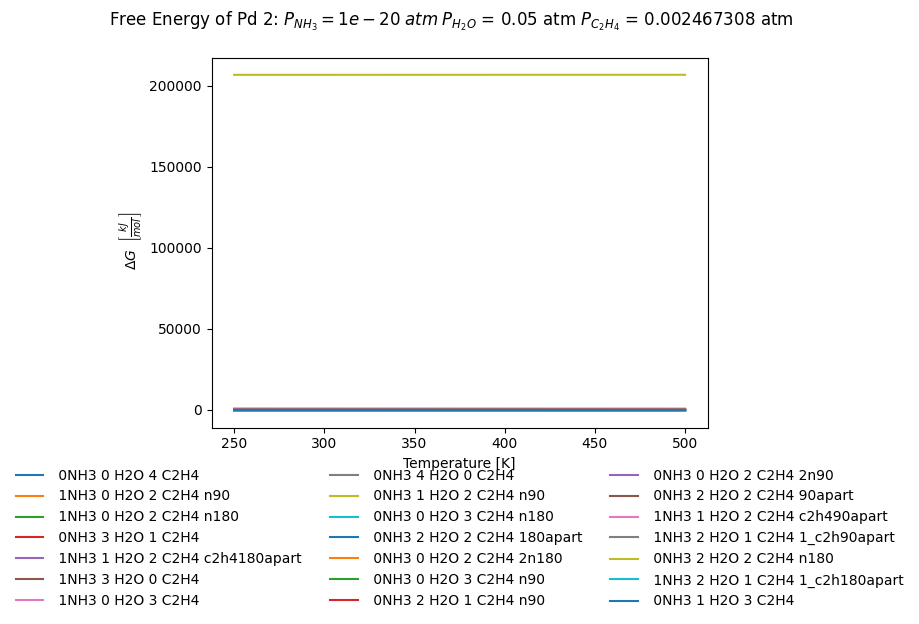

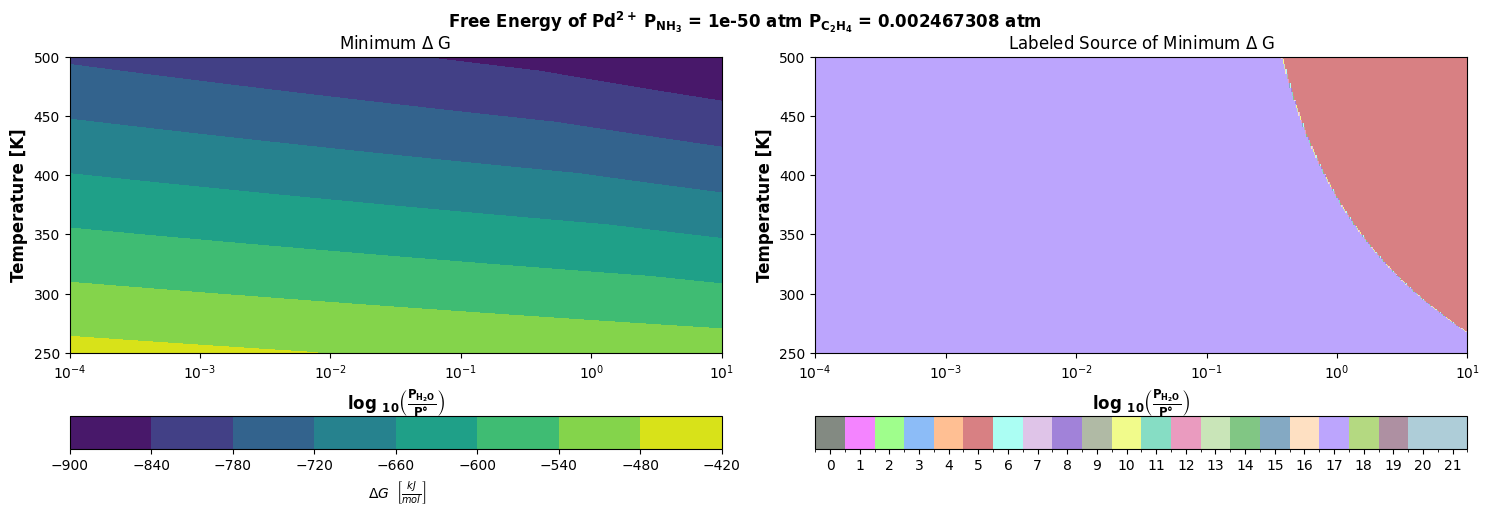

In [300]:
# VARY TEMP

cu2 = fourfold(data = rxn_df, temperature = interp_temp, p_nh3 = 1e-20, p_h2o = 0.05, p_c2h4 = 0.002467308, in_cond=init_cond)

# vary_temp_outfile = '/Users/mohan/Desktop/no_mu.png'

# cu2.plot_no_mu()

# cu2.plot_no_mu_single(index = 1)

cu2.plot_vary_temp()

# for values in test:
#     plt.plot(interp_temp, values)
# plt.show();
#-------------------------------------------------------------------------------- */
# VARY TEMP, P_H2O

pres_step = 0.01

p = np.arange(-4, 1+pres_step, pres_step)

pressure_h2o = np.power(10, p) # units atm

cu2_sp = fourfold(data = rxn_df, temperature = interp_temp, p_nh3 = 1e-50, p_h2o = pressure_h2o, p_c2h4 = 0.002467308, in_cond=init_cond)

vary_temp_ph2o_outfile = '/Users/mohan/Desktop/contour_T_h2o.png'

cu2_sp.plot_vary_temp_ph2o(vary_temp_ph2o_outfile)

In [301]:
rxn_df

,Metal,Charge,Geometry,NH3,H2O,C2H4,Description,Total Energy (Hartree),ZPE (kJ/mol),File Path,Entropy (kJ/mol*K),Delta E (kJ/mol),Delta S (kJ/mol*K)
0,Pd,2,Square planar,0,0,4,,-441.309638,555.996631,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.42097665224601477, 0.42101410572052556, 0.4...",0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Pd,2,Square planar,1,0,2,n90,-340.797516,376.668381,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.3341725383207743, 0.3341942876157616, 0.334...",51.693559,"[-0.08680411392524046, -0.08681981810476397, -..."
2,Pd,2,Square planar,1,0,2,n180,-340.792663,373.478670,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.34567905855293, 0.3457015971504484, 0.34572...",64.436959,"[-0.07529759369308475, -0.07531250857007715, -..."
3,Pd,2,Square planar,0,3,1,,-434.876410,335.413556,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.36831309611363605, 0.3683413505695188, 0.36...",-35.380635,"[-0.05266355613237872, -0.05267275515100678, -..."
4,Pd,2,Square planar,1,1,2,c2h4180apart,-417.203728,443.621472,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.39155342703865303, 0.3915844515142171, 0.39...",-112.978554,"[-0.029423225207361736, -0.029429654206308442,..."
5,Pd,2,Square planar,1,3,0,,-412.907647,299.564815,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.3552611886877602, 0.35528676692720546, 0.35...",-117.498394,"[-0.06571546355825458, -0.0657273387933201, -0..."
6,Pd,2,Square planar,1,0,3,,-419.346217,518.260738,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.3991422437068075, 0.3991753759168507, 0.399...",-96.143567,"[-0.021834408539207262, -0.02183872980367485, ..."
7,Pd,2,Square planar,0,4,0,,-432.719179,264.934707,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.3603013798808495, 0.36032821150381317, 0.36...",-13.511452,"[-0.06067527236516529, -0.06068589421671239, -..."
8,Pd,2,Square planar,0,1,2,n90,-360.618231,340.798166,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.3587549014528096, 0.35878036930848795, 0.35...",131.573790,"[-0.06222175079320519, -0.06223373641203761, -..."
9,Pd,2,Square planar,0,0,3,n180,-362.707647,406.996734,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.34574881358037124, 0.3457716106679087, 0.34...",287.751388,"[-0.07522783866564353, -0.07524249505261688, -..."


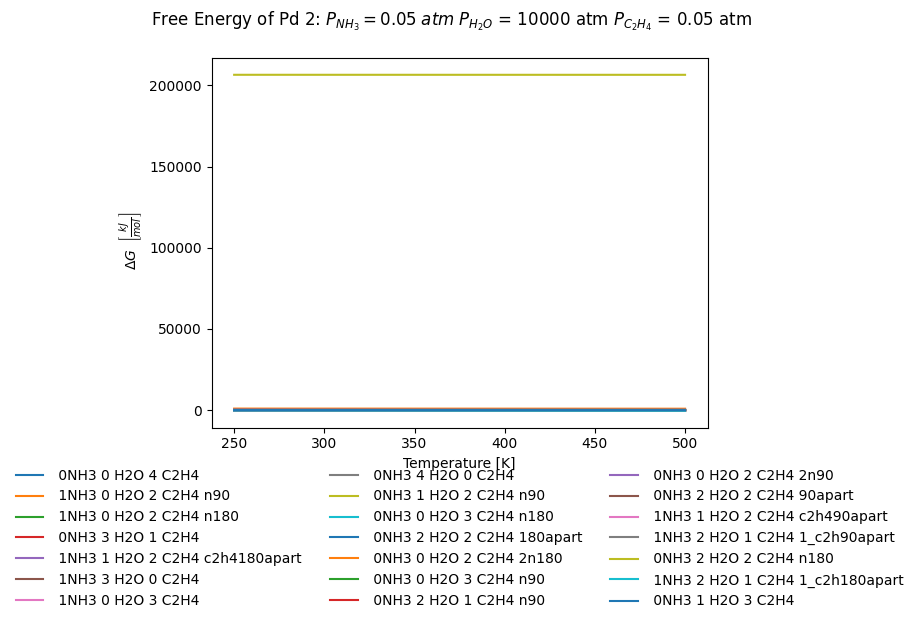

In [302]:
cu2 = fourfold(data = rxn_df, temperature = interp_temp, p_nh3 = 0.05, p_h2o = 10000, p_c2h4 = 0.05, in_cond=init_cond)

cu2.plot_vary_temp('/Users/mohan/Desktop/ex.png')

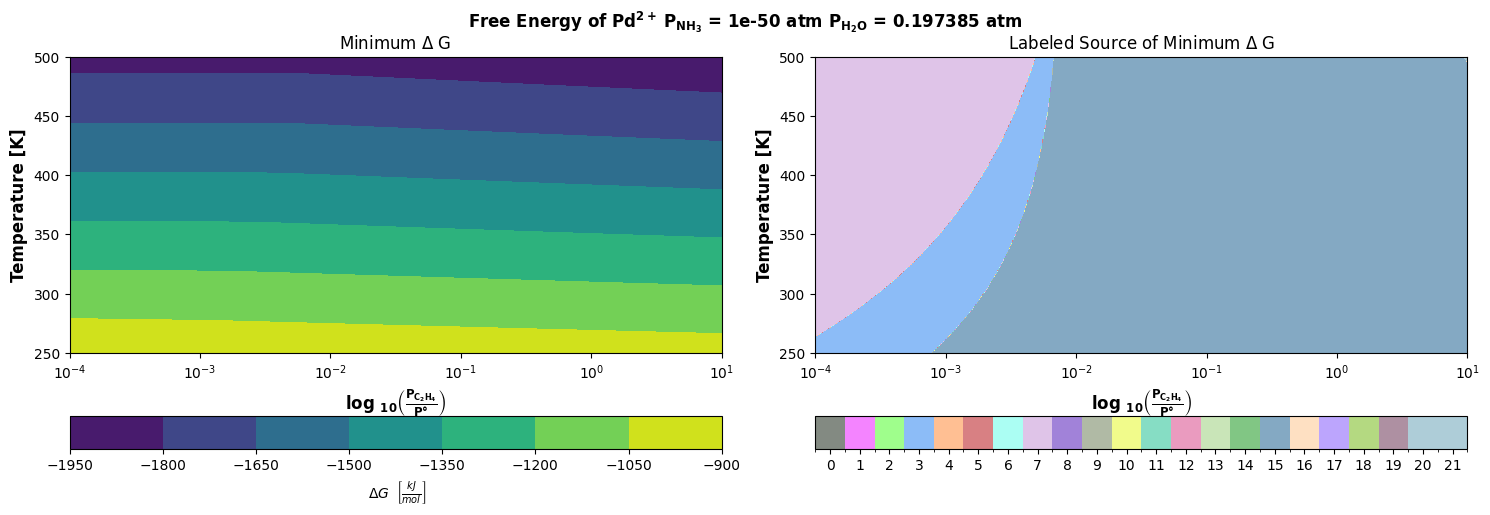

In [303]:
#-------------------------------------------------------------------------------- */
# VARY TEMP, P_C2H4

pres_step = 0.005

p = np.arange(-4, 1+pres_step, pres_step)

pressure_c2h4 = np.power(10, p) # units atm

cu2_sp = fourfold(data = rxn_df, temperature = interp_temp, p_nh3 = 1e-50, p_h2o = 0.197385, p_c2h4 = pressure_c2h4, in_cond=init_cond)

# dE_TdS_mu, mu_nh3, mu_h2o, mu_c2h4 = cu2_sp.vary_temp_ph2o()

vary_temp_pc2h4_outfile = '/Users/mohan/Desktop/contour_T_c2h4.png'

cu2_sp.plot_vary_temp_pc2h4(vary_temp_pc2h4_outfile)


In [305]:
rxn_df

,Metal,Charge,Geometry,NH3,H2O,C2H4,Description,Total Energy (Hartree),ZPE (kJ/mol),File Path,Entropy (kJ/mol*K),Delta E (kJ/mol),Delta S (kJ/mol*K)
0,Pd,2,Square planar,0,0,4,,-441.309638,555.996631,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.42097665224601477, 0.42101410572052556, 0.4...",0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Pd,2,Square planar,1,0,2,n90,-340.797516,376.668381,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.3341725383207743, 0.3341942876157616, 0.334...",51.693559,"[-0.08680411392524046, -0.08681981810476397, -..."
2,Pd,2,Square planar,1,0,2,n180,-340.792663,373.478670,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.34567905855293, 0.3457015971504484, 0.34572...",64.436959,"[-0.07529759369308475, -0.07531250857007715, -..."
3,Pd,2,Square planar,0,3,1,,-434.876410,335.413556,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.36831309611363605, 0.3683413505695188, 0.36...",-35.380635,"[-0.05266355613237872, -0.05267275515100678, -..."
4,Pd,2,Square planar,1,1,2,c2h4180apart,-417.203728,443.621472,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.39155342703865303, 0.3915844515142171, 0.39...",-112.978554,"[-0.029423225207361736, -0.029429654206308442,..."
5,Pd,2,Square planar,1,3,0,,-412.907647,299.564815,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.3552611886877602, 0.35528676692720546, 0.35...",-117.498394,"[-0.06571546355825458, -0.0657273387933201, -0..."
6,Pd,2,Square planar,1,0,3,,-419.346217,518.260738,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.3991422437068075, 0.3991753759168507, 0.399...",-96.143567,"[-0.021834408539207262, -0.02183872980367485, ..."
7,Pd,2,Square planar,0,4,0,,-432.719179,264.934707,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.3603013798808495, 0.36032821150381317, 0.36...",-13.511452,"[-0.06067527236516529, -0.06068589421671239, -..."
8,Pd,2,Square planar,0,1,2,n90,-360.618231,340.798166,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.3587549014528096, 0.35878036930848795, 0.35...",131.573790,"[-0.06222175079320519, -0.06223373641203761, -..."
9,Pd,2,Square planar,0,0,3,n180,-362.707647,406.996734,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.34574881358037124, 0.3457716106679087, 0.34...",287.751388,"[-0.07522783866564353, -0.07524249505261688, -..."
